# Assignment 3
## Exercise 1 + 2
### Import everything

In [1]:
from cifar_helper import CIFAR # note we renamed the helper file so it doesn't syntax error
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
SEED = 5
np.random.seed(SEED)

### Create a CIFAR data loader
We are using the one that was provided. We had to import `numpy` there because it was missing as a dependency. We've also removed the seeding statement.

In [3]:
import os
import numpy as np
import pickle

class CIFAR():
    # make sure you have the data in this directory or pass another
    def __init__(self, directory="./data"):
        self._directory = directory

        self._training_data = []
        self._training_labels = []
        self._test_data = []
        self._test_labels = []

        self._load_traing_data()
        self._load_test_data()

        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)

        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)


    def _load_traing_data(self):
        for i in range(1, 6):
            path = os.path.join(self._directory, "data_batch_" + str(i))
            with open(path, 'rb') as fd:
                cifar_data = pickle.load(fd, encoding = "bytes")
                imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
                imgs = imgs.transpose([0, 2, 3, 1])
                if i == 1:
                    self._training_data = imgs
                    self._training_labels = cifar_data[b"labels"]
                else:
                    self._training_data = np.concatenate([self._training_data, imgs], axis = 0)
                    self._training_labels = np.concatenate([self._training_labels, cifar_data[b"labels"]])

    def _load_test_data(self):
        path = os.path.join(self._directory, "test_batch")
        with open(path, 'rb') as fd:
            cifar_data = pickle.load(fd, encoding = "bytes")
            imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
            self._test_data = imgs.transpose([0, 2, 3, 1])
            self._test_labels = np.array(cifar_data[b"labels"])

    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)

    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)

    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)

    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n

        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]


    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n


In [4]:
cifar = CIFAR("data")

## Exercise 3 - Investigating the data

In [5]:
# Get some data to inspect.
test_batch = list(zip(cifar._training_data[:16], cifar._training_labels[:16]))

# Define the categories that correspond to the numeric labels.
categories = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse',
        'Ship', 'Truck']
f, axarr = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        index = 4 * i + j
        ax = axarr[i][j]
        img = test_batch[index][0]
        label = test_batch[index][1]
        ax.set_title(categories[label])
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

<IPython.core.display.Javascript object>

## Exercise 4

How many neurons are simulated? How many weights (DoF) does the network hav? How many floating point operations are necessary for a forward pass of the network?

### Layer One: Conv Layer
    
    24*24 = 576 Neurons

    16 Kernels of size (5,5,3)
    5*5*3*16 = 9216 weights
    
    576 * 9216 = 5308416 floating point operations
    

### Layer Two: Max Pooling
    
    24*24 -> 12*12=144 neurons

    no weights
    
    24*24 = 576 floating point operations

### Layer Three: Conv Layer

    144 Neurons
    
    32 Kernels with size (3,3,16)
    32*16*3*3 = 4608 weights
    
    144 * 4608 = 663552 floating point operations

### Layer Four: Pooling
    
    12*12 -> 6*6 = 36 neurons
    
    no weights
    
    12*12 = 144 floating point operations
    
### Layer Five: fully connected

    2048 neurons
    
    36*2048 = 73728 weights
    
    36*(2048+2047) + 2048 = 147420 floating point operations

### Layer Six: fully connected

    512 neurons
    
    2048*512 = 1048576 weights
    
    2048*(512+511) + 512 = 2095616 floating point operations

### Output: 

    10 neurons
    
    512*10 = 5120 weights
    
    512*(10+9) + 10 = 9738 floating point operations

### Total:

    Number of neurons: (576 + 144 + 144 + 36) + (2048 + 512 + 10) = 3470.
    
    Number of weights (DoF): (9216 + 0 + 4608 + 0) + (73728 + 1048576 + 5120) = 1141248.
    
    Floating point operations: (5308416 + 576 + 663552 + 144) + (147420 + 2095616 + 9738) = 8225462.



## Exercise 5
In this section, we implement the graph.

We first define helper functions for layer creation.


In [6]:
# counter for autmatically creating conv layer variable names
conv_n = 0

def conv_layer(input, kshape, strides=(1, 1, 1, 1)):
    '''Create a convolutional layer with fixed activation function and variable
    initialisation. The activation function is ``tf.nn.tanh`` and variables are
    initialised from a truncated normal distribution with an stddev of 0.1

    Parameters
    ----------
    input   :   tf.Variable
                Input to the layer
    kshape  :   tuple or list
                Shape of the kernel tensor
    strides :   tuple or list
                Strides

    Returns
    -------
    tf.Variable
            The variable representing the layer activation (tanh(conv + bias))

    '''
    global conv_n
    conv_n += 1
    # this adds a prefix to all variable names
    with tf.variable_scope('conv%d' % conv_n):
        # We initialize bias + kernel with values from a truncated normal
        kernels = tf.Variable(tf.truncated_normal(kshape, stddev=0.1, seed=SEED),
                kshape)
        bias_shape = (kshape[-1],)
        biases = tf.Variable(tf.truncated_normal(bias_shape, stddev=0.1, seed=SEED))
        # Here we are defining the convolution operation by applying kernel to the input, aka the images.
        # Stride is (1,1,1,1) and padding is SAME since we want to keep the dimensions.
        conv = tf.nn.conv2d(input, kernels, strides, padding='SAME', name='conv')
        activation = tf.nn.tanh(conv + biases, name='activation')
        return activation

  # counter for autmatically creating fully-connected layer variable names
fc_n = 0
def fully_connected(input, n_out, with_activation=False):
    '''Create a fully connected layer with fixed activation function and variable
    initialisation. The activation function is ``tf.nn.tanh`` and variables are
    initialised from a truncated normal distribution with an stddev of 0.1

    Parameters
    ----------
    input   :   tf.Variable
                Input to the layer
    n_out   :   int
                Number of neurons in the layer
    with_activation :   bool
                        Return activation or drive (useful when planning to use
                        ``softmax_cross_entropy_with_logits`` which requires
                        unscaled logits)


    Returns
    -------
    tf.Variable
            The variable representing the layer activation (tanh(input * Weights
            + bias))
    '''
    global fc_n
    fc_n += 1
    with tf.variable_scope('fully%d' % fc_n):
        init = tf.truncated_normal_initializer(stddev=0.1, seed=SEED)
        W = tf.get_variable(
                'weights',
                initializer=init,
                shape=(input.shape[-1], n_out),     # the last dim of the input
               dtype=tf.float32                     # is the first dim of the weights2
            )
        bias = tf.get_variable('bias', initializer=init, shape=(n_out,))
        drive = tf.matmul(input, W) + bias
        if with_activation:
            return tf.nn.tanh(drive)
        else:
            return drive
  

## Exercise 6
The `train` function trains the network.

In [7]:
def train(batch_size=500, learning_rate=1e-4, epochs=10, record_step=20):
    '''Train the fixed graph on CIFAR-10.

    Parameters
    ----------
    batch_size  :   int
                    Size of training batch
    learning_rate   :   float
                        Learning rate for the ADAM optimizer
    epochs          :   int
                        Number of times to visit the entire training set
    record_step     :   int
                        Accuracy on test set will be recorded every
                        ``record_step`` training steps

    Returns
    -------
    tuple
            Array of cross entropies and array of test accuracies in a tuple
    '''

    assert batch_size > 0, 'Batch size must be positive'
    assert learning_rate > 0, 'Learning rate must be positive'
    assert epochs > 0, 'Number of epochs must be positive'
    assert record_step > 0, 'Recording step must be positive'

    # Reset graph in order to cope with multiple cell executions.
    tf.reset_default_graph()

    # Define placeholders for both the input x and the labels l.
    x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input')
    l = tf.placeholder(dtype=tf.uint8, shape=(None, 1), name='labels')
    # The labels are encoded as one-hot vectors.
    l_one_hot = tf.squeeze(tf.one_hot(l, 10), axis=1)


    #############
    # LAYER ONE #
    #############
    # There are 16 Kernels with a shape of 5x5x3 each, plus a bias.
    kernel_shape1 = (5, 5, 3, 16)
    activation1 = conv_layer(x, kernel_shape1)
    
    #############
    # LAYER TWO #
    #############
    # Now we are pooling the results with a 2x2 kernel in order to get 16 16x16 feature maps.
    pool1 = tf.nn.max_pool(activation1, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

    kernel_shape2 = (3, 3, 16, 32)
    activation2 = conv_layer(pool1, kernel_shape2)

    ###############
    # LAYER THREE #
    ###############
    # Again we are pooling the results with a 2x2 kernel in order to get 32 8x8 feature maps.
    pool2 = tf.nn.max_pool(activation2, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')

    ##############
    # LAYER FIVE #
    ##############

    # Now we want to direct the output into a FFNN. For that reason we have to reshape the data into
    # a vector format.
    pool2_reshaped = tf.reshape(pool2, (-1, 2048), name='reshaped1')

    # There are 512 neurons that are connected to 8*8*32=2048 kernel pixels.
    fc1 = fully_connected(pool2_reshaped, 512, with_activation=True)

    #############
    # LAYER SIX #
    #############

    fc2_logit = fully_connected(fc1, 10)

    # for the last layer we are choosing a softmax activation function and, like in previous
    # homeworks, reduce the cross entropy during training.
    cross_entropy      = tf.nn.softmax_cross_entropy_with_logits(logits=fc2_logit, labels=l_one_hot)
    mean_cross_entropy = tf.reduce_mean(cross_entropy)
    
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(mean_cross_entropy)

    correct_prediction = tf.equal(tf.argmax(fc2_logit, 1), tf.argmax(l_one_hot, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    
    cifar = CIFAR('data')
    ###############################################
    #  Pointless array preallocation for records  #
    ###############################################
    N, _, _= cifar.get_sizes()
    n_propagations = (N // batch_size)
    if N % batch_size != 0:
        n_propagations += 1
    n_entropies = n_propagations * epochs
    entropies = np.zeros(n_entropies, dtype=np.float32)
    n_accuracies = n_entropies // record_step
    if n_entropies % record_step != 0:
        n_accuracies += 1
    accuracies = np.zeros(n_accuracies, dtype=np.float32)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        propagation = 0
        accu_counter = 0
        for epoch in range(epochs):
            print('Starting epoch %d' % epoch)
            for data, labels in cifar.get_training_batch(batch_size):
                entropy, _ = sess.run([mean_cross_entropy, train_step],
                        feed_dict={x: data, l: labels[:, np.newaxis]})
                entropies[propagation] = entropy
                if propagation % record_step == 0:
                    test_acc = sess.run([accuracy], feed_dict={x:
                        cifar._test_data, l: cifar._test_labels[:,
                            np.newaxis]})
                    accuracies[accu_counter] = test_acc[0]
                    accu_counter += 1
                    print('Current test accuracy %f' % test_acc[0])
                propagation += 1
    return entropies, accuracies


### Evaluation

Starting epoch 0
Current test accuracy 0.097500
Current test accuracy 0.206700
Current test accuracy 0.272500
Current test accuracy 0.304600
Current test accuracy 0.330700
Starting epoch 1
Current test accuracy 0.341200
Current test accuracy 0.358500
Current test accuracy 0.361800
Current test accuracy 0.377000
Starting epoch 2
Current test accuracy 0.381700
Current test accuracy 0.385600
Current test accuracy 0.396100
Current test accuracy 0.401800
Current test accuracy 0.404200


<IPython.core.display.Javascript object>


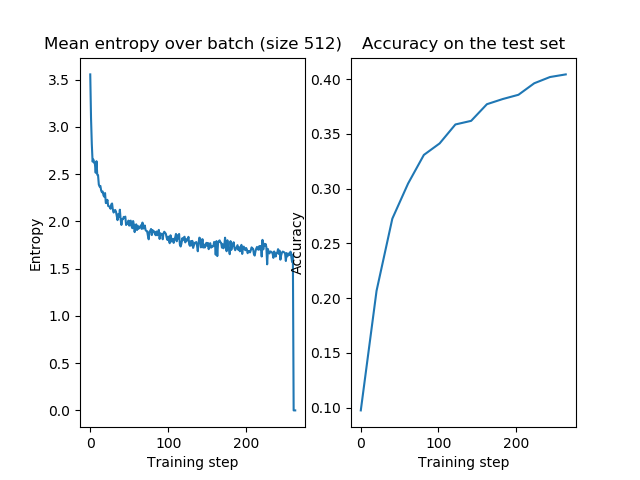

In [9]:
# Note that we purposefully omitted plotting entropies/accuracies
# for the training set, as that isn't very interesting to us
batch_size = 512
epochs = 3
entropies, accuracies = train(
    batch_size=batch_size, epochs=epochs)
f = plt.figure()
ax = f.add_subplot(121)
ax.set_title('Mean entropy over batch (size %d)' % batch_size)
ax.set_xlabel('Training step')
ax.set_ylabel('Entropy')
                                                                          
ax2 = f.add_subplot(122)
ax2.set_title('Accuracy on the test set')
ax2.set_xlabel('Training step')
ax2.set_ylabel('Accuracy')
                                                                          
ax.plot(entropies)
ax2.plot(np.linspace(0, len(entropies), num=len(accuracies)), accuracies)
plt.show()




### Optimizations

We tried the following angles:
* We tried all optimizers which TF provides
* Learning rates from 0.1 to 0.0001
* Batch sizes from 50 to 4000
* We added a dropout to layers 1 and 2, but as far as I understand it, that reduces overfitting, but doesn't improve network potency as such.
* We added another conv layer
* We tried ReLU activations

We trained for 35 epochs. The result was that we never reached much more than 60% accuracy. The winner on the original network was RMSProp with learning rate 0.001 and batch size 500. We assume the network is simply not capable of much more.